# Trackster-level graph net with PU

Question: does including the neughbourhood provide benefir over pairwise classification?

In [2]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import SGD
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import EdgeConvBlock

import sklearn.metrics as metrics

from reco.training import train_edge_pred, test_edge_pred, precision_recall_curve, roc_auc
from reco.loss import FocalLoss
from reco.datasetPU import TracksterGraphPU


ds_name = "CloseByGamma200PUFull"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [3]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [24]:
def create_mask(data):
    # extract the focus feature
    data.mask = (1 - data.x[:,0]).type(torch.bool)
    return data

def knn_transform(data):
    # pos coordinates are on position 3:6
    data.edge_index = knn_graph(data.x[:,3:6], k=8, loop=False)
    return data

transforms = T.Compose([knn_transform, create_mask])

In [29]:
# Dataset TODO: use ds.pos, use ds.mask

ds = TracksterGraphPU(
    ds_name,
    data_root,
    raw_dir,
    transform=transforms,
    N_FILES=464,
    radius=10,
)

ds.processed_file_names

['TracksterGraphPU_CloseByGamma200PUFull_f464_r10_s0.2.pt']

In [30]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}")

train_dl = DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = DataLoader(test_set, batch_size=32, shuffle=True)

Train graphs: 4724, Test graphs: 524


In [31]:
to_predict = []
for data in ds:
    to_predict += data.y[data.mask].tolist()
query_labels = np.array(to_predict)

print("Labels (one per trackster minus the main trackster):", len(query_labels))
print("Positive:", int((query_labels > 0.8).astype(int).sum()))
print("Negative:", int((query_labels < 0.8).astype(int).sum()))

Labels (one per trackster minus the main trackster): 175356
Positive: 6584
Negative: 168772


In [32]:
balance = float(sum(query_labels > 0.8) / len(query_labels))
print(f"dataset balance: {balance * 100:.2f}%") 

dataset balance: 3.75%


In [33]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.2):
        super(TracksterGraphNet, self).__init__()
        
        hdim1 = 64
        hdim2 = 128
        hdim_fc = 256

        # EdgeConv
        self.graphconv1 = EdgeConvBlock(input_dim, hdim1)
        self.graphconv2 = EdgeConvBlock(hdim1, hdim2)
        
        # Edge features from node embeddings for classification        
        self.edgenetwork = nn.Sequential(
            nn.Linear(hdim2, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
            nn.Sigmoid()
        )
            
    def forward(self, X, edge_index):   
        H = self.graphconv1(X, edge_index)
        H = self.graphconv2(H, edge_index)
        return self.edgenetwork(H).squeeze(-1)

In [34]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1])
epochs = 101
model_path = f"models/TracksterGraphNet.KNN.mask.64.128.256.ns.{epochs}e-{ds_name}.{ds.RADIUS}.{ds.SCORE_THRESHOLD}.{ds.N_FILES}f.pt"

In [35]:
# %%script echo skipping

# alpha - percentage of negative edges
loss_func = FocalLoss(alpha=0.25, gamma=2)

model = model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-3)

for epoch in range(epochs):

    train_loss, train_true, train_pred = train_edge_pred(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    train_auc = metrics.roc_auc_score((train_true > 0.8).astype(int), train_pred)
    scheduler.step()

    if epoch % 10 == 0:
        test_loss, test_true, test_pred = test_edge_pred(model, device, loss_func, test_dl)
        test_auc = metrics.roc_auc_score((test_true > 0.8).astype(int), test_pred)
        print(
            f"Epoch {epoch}",
            f"\ttrain loss:{train_loss:.3f}\ttrain auc: {train_auc:.3f}",
            f"\t test loss:{test_loss:.3f} \t test auc: {test_auc:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0 	train loss:128.816	train auc: 0.563 	 test loss:7.759 	 test auc: 0.748
Epoch 10 	train loss:39.428	train auc: 0.928 	 test loss:3.872 	 test auc: 0.940
Epoch 20 	train loss:31.875	train auc: 0.947 	 test loss:3.219 	 test auc: 0.952


KeyboardInterrupt: 

In [57]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


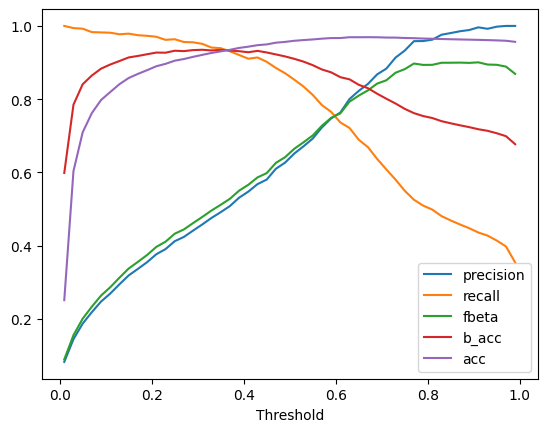

TP: 516, TN: 16412, FP: 2, FN: 668
TH: 0.91 precision: 0.996 recall: 0.436 fbeta: 0.901 b_acc: 0.718 acc: 0.962


In [61]:
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.3, step=2)

In [62]:
print(roc_auc(model, device, test_dl))

0.9796687032164368

## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796